In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy
from scipy.integrate import odeint
import math as m
from scipy.optimize import curve_fit

In [2]:
#We choose to convert the .csv file to .xls format and use pandas to parse it:
data = pd.ExcelFile("COVID19_Data_Spain.xls")
sheetX = data.parse(0) 
date = sheetX['Date']
infected = sheetX['Infected']
deaths = sheetX['Deaths']
recovered = sheetX['Recovered']
dt = np.linspace(1,len(infected),len(infected))
a = (1/2.3)
ro = (1/5.2)

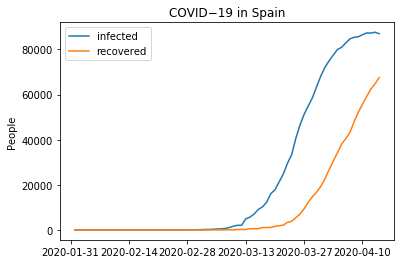

In [3]:
#Plotting real data:
plt.figure(1)
plt.plot(date,infected,label='infected')
plt.plot(date,recovered,label='recovered')
plt.title('COVID−19 in Spain')
plt.ylabel('People')
plt.legend(loc = 'best')
plt.show()

#### Scenario 1: estimating infection rate (r)
Sweep approach to find r and S0

In [4]:
def SIR(I_cond,dt,r,a):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - a*I0
    drdt = a*I0
    return dsdt,didt,drdt

def SEIR(I_cond,dt,r,a,ro):
    S0,I0,R0,E0 = I_cond
    dsdt = -r*S0*I0
    dedt = r*S0*I0 - ro*E0
    didt = ro*E0 -a*I0
    drdt = a*I0
    return dsdt,dedt,didt,drdt

In [36]:
#Caso SIR model sweep:
Ns = np.linspace(10.3**6,10.6**6,50)
Rs = np.linspace(0.545e-6,0.45e-6,50)

mse = []
for n in Ns:
    mse_n = []
    for r in Rs:
        I_cond = np.array([n,infected[0],recovered[0]])
        model_SIR = odeint(SIR,I_cond,dt,args = (r,a))
        mse_r = np.sum((model_SIR[:,1]-infected)**2)/len(infected)
        mse_n.append(mse_r)
    for m in mse_n:
        mse.append(m)

best_fit = min(mse)
index = mse.index(best_fit)
Ns_index = int(index/50)
Rs_index = int(index/50)
print('Best fit: number of population'+' '+str(Ns[Ns_index])+', '+'value of r:'+' '+str(Rs[Rs_index]))

50
Best fit: number of population 1418519.1122559998, value of r: 4.5e-07


Curve fitting approach to find r and S0

In [6]:
#Caso SIR model fitting
def SIR2(I_cond,dt,r):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - (1/2.3)*I0
    drdt = (1/2.3)*I0
    return dsdt,didt,drdt

def evolution_SIR(t,r,S0):
    return odeint(SIR2,[S0,1,0],t,args = (r,))[:,1]

In [23]:
params_SIR,params_covariance_SIR = curve_fit(evolution_SIR,dt,infected,[0.45e-6,1.4e6]) #Pillo los del sweep
r_value_SIR = params_SIR[0]
S0_value_SIR = params_SIR[1]
print('The value for r is equal to (SIR):',r_value_SIR)
print('The value for the initial susceptible population is (SIR):',S0_value_SIR)

The value for r is equal to (SIR): 3.7798833392236435e-07
The value for the initial susceptible population is (SIR): 1682182.7173673168


#### Scenario 1: predicting when R0 becomes <1 and when the epidemic ends

In [8]:
#R0<1 and the end of the epidemic:
fit_SIR = evolution_SIR(dt,r_value_SIR,S0_value_SIR)
maximum = max(fit_SIR)
tmax = np.where(fit_SIR==maximum)
print('R_0<1:'+str(tmax[0]))

dt_extended = np.linspace(1,300,300)
fit_SIR_extended = evolution_SIR(dt_extended,r_value_SIR,S0_value_SIR)

fin_SIR = 0
cont = 0
for individual in fit_SIR_extended:
    if individual < 1:
        fin_SIR = cont + 2 #0-indexing
        break 
    else: 
        cont = cont+1
print('No more people will get infected after '+str(fin_SIR)+' days of epidemic.')

R_0<1:[65]
No more people will get infected after 150 days of epidemic.


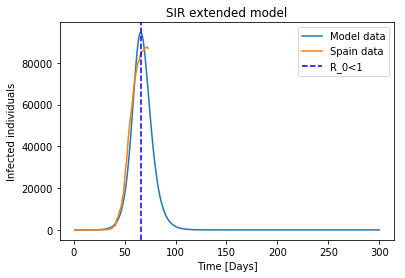

In [9]:
#Representación del resutlado:
plt.figure(1)
plt.plot(dt_extended,fit_SIR_extended,label='Model data')
plt.plot(dt,infected,label='Spain data')
plt.axvline(66,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()

#### Scenario 2: Model pre-confinment

In [82]:
#We consider the starting date of the confinment the day 43
day_conf=43
dt_pre_conf=np.linspace(1,day_conf,day_conf)
infected_pre_conf=list(infected[0:day_conf])

#r_value_SIR_pre = r_value_SIR 
#S0_value_SIR_pre = S0_value_SIR 
#print('The value for r before confinment is equal to (SIR):',r_value_SIR)
#print('The value for the initial susceptible population before confinment is (SIR):',S0_value_SIR)

results_pre = odeint(SIR2,[S0_value_SIR_pre,1,0],dt_pre_conf,args = (r_value_SIR_pre,))
S, I, R = results_pre.T
S_new=S[-1]
I_new=I[-1]
R_new=R[-1]
print('The intial conditions for the confinment are S0 = ',S[-1],', I0 = ',I[-1],', R0 = ',R[-1])

The intial conditions for the confinment are S0 =  1667742.2094741564 , I0 =  4524.655521675517 , R0 =  9916.85237148456


In [83]:
#Caso SIR model fitting durante la cuarentena
def SIR_conf(I_cond,dt,r,q):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - (1/2.3)*I0-q*I0
    drdt = (1/2.3)*I0+q*I0
    return dsdt,didt,drdt

def evolution_SIR_conf(t,q):
    return odeint(SIR_conf,[S_new,I_new,R_new],t,args = (r_value_SIR,q))[:,1]

Encontrar rango de q con sweep

In [114]:
dt_conf = np.linspace(1,len(infected)-day_conf,len(infected)-day_conf)
infected_conf = infected[day_conf:]

q_sweep = np.linspace(1e-3,1e-2,50)


mse_c = []
for q in q_sweep:
    model_SIR_conf = odeint(SIR_conf,[S_new,I_new,R_new],dt_conf,args = (r_value_SIR,q))
    S, I, R = model_SIR_conf.T
    mse_r = np.sum((I-infected_conf)**2)/len(infected_conf)
    mse_c.append(mse_r)
        
best_fit = min(mse_c)
index = mse_c.index(best_fit)
q_sweep_index = int(index/50)
print(mse_c)
print('Best fit: number of q'+' '+str(q_sweep[q_sweep_index]))

[97720515.490075, 98016569.45156176, 98338888.55508783, 98687399.7899721, 99062030.1505324, 99462706.63386868, 99889356.24214618, 100341905.98082155, 100820282.85817102, 101324413.88546371, 101854226.07666785, 102409646.44712137, 102990602.01474343, 103597019.79904419, 104228826.82085222, 104885950.10458188, 105568316.67558895, 106275853.55964611, 107008487.78497627, 107766146.38061021, 108548756.37348242, 109356244.79037443, 110188538.66212672, 111045565.01965684, 111927250.89413758, 112833523.31585433, 113764309.31453276, 114719535.91879182, 115699130.15333156, 116703019.03881438, 117731129.6021835, 118783388.86984205, 119859723.8666177, 120960061.615244, 122084329.13633578, 123232453.4485829, 124404361.56697537, 125599980.5041235, 126819237.27241401, 128062058.88128333, 129328372.33866914, 130618104.64717826, 131931182.8057515, 133267533.8098183, 134627084.6333393, 136009762.30833343, 137415493.82209936, 138844206.1578784, 140295826.2965383, 141770281.21571115]
Best fit: number of q

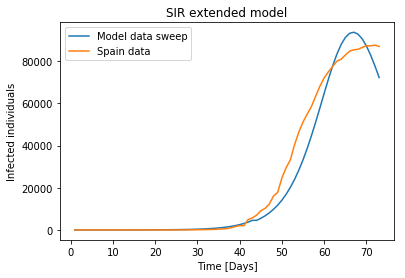

In [121]:
#Representación del resutlado:
q=q_sweep[q_sweep_index]


sweep_SIR_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,q))
#sweep_SIR_conf=odeint(SIR2,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,))
S_sweep_conf, I_sweep_conf, R_sweep_conf = sweep_SIR_conf.T

I_conf=list(fit_SIR_extended[0:day_conf])
I_conf.extend(I_sweep_conf)

plt.figure(1)
plt.plot(dt,I_conf,label='Model data sweep')
plt.plot(dt,infected,label='Spain data')
#plt.axvline(66,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
#print(I_conf)

Encontrar q con curve_fit

In [116]:
params_SIR_conf,params_covariance_SIR_conf = curve_fit(evolution_SIR_conf,dt_conf,infected_conf,1e-3) 
q_value_SIR_conf = params_SIR_conf

print('The value for q is equal to:',q_value_SIR_conf)

The value for q is equal to: [-0.00094437]


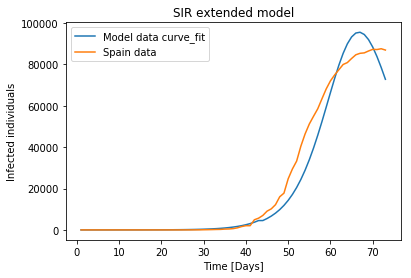

In [122]:
#Representación del resutlado:
q=q_value_SIR_conf


sweep_SIR_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,q))
#sweep_SIR_conf=odeint(SIR2,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,))
S_sweep_conf, I_sweep_conf, R_sweep_conf = sweep_SIR_conf.T

I_conf=list(fit_SIR_extended[0:day_conf])
I_conf.extend(I_sweep_conf)

plt.figure(1)
plt.plot(dt,I_conf,label='Model data curve_fit')
plt.plot(dt,infected,label='Spain data')
#plt.axvline(66,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
#print(I_conf)